# Import Packages

In [49]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as kb
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import pickle
from google.colab import files
from tensorflow import math

# Custom loss
Keras has already a loss function to compute categorical cross entropy loss but this function only support vectors. Model output and label is a matrix of 36 by 5 so there needs a custom loss function to compute cross entropy loss on each column and compute summation.

In [50]:
class Custom_Loss(tf.keras.losses.Loss):
    
    def __init__(self):
        super().__init__()
        self.cce = tf.keras.losses.CategoricalCrossentropy()
        
    def call(self, y_true, y_pred):
      """
      y_true: labels of size (batch_size, number of categories, number of words or numbers on each image)
      y_pred: model output of size (batch_size, number of categories, number of words or numbers on each image)
      """
      cce = 0                                              #loss at the first stage
      for i in range(y_pred.shape[2]): 
        cce += self.cce(y_true[:, :, i], y_pred[:, :, i])  #compute loss on every predicted word or numbers separately and get sum
      return cce

# Model
This class include of 5 different methods.
### **Load Image**
This method get image path as input. first read file then decode it to tensor as gray scale (only 1 channel) then resize image to have square image and at last normalize it.
### **Label Encoder**
This method encode list of labels to one hot.
### **Load Data**
This method get directory of images, batch size, train and validation split rate as inputs to create traiing, validation and test datasets of images and one hot encoded of labels.
### **Load Model**
This mothod create and compile cnv model include of 6 conv + pool + batchN part and 5 different FC layer that each FC predict one word or number in the image
### **Custom Accuracy**
Beacause of 2D tensor as output of this model, there is need to define a custom metric to evaluate model performance. this metric compare each element of output with label and if even one difference between model and output has been seen, it labeled as wrong prediction. at the end compute accuracy as number of right predictions over all of predictions and this is what we need when we are going to predict captcha, one single mistake would be rejected by the way.

In [214]:
class NN():
  
  def __init__(self):
    self.height = 100                                                 #desired hieght of input image
    self.width = 100                                                  #desired width of input image
  
  def __load_image(self, path : str):
    """
    path: image path
    """
    
    image = tf.io.read_file(path)                                     #read image file
    image = tf.io.decode_png(image, channels=1)                       #convert image file to tensor and include only one channel
    image = tf.image.resize(image, [self.width, self.height])         #resize to have square image for better result
    image = tf.cast(image, tf.float32)                                #cast to float before needed before division for narmalization
    image = tf.divide(image, 255.)                                    #divide to 255 to normalize
    return image

  def __encode_label(self, labels : list):
    """
    labels: list of string images labels
    """
    
    labels_dict = {}                                                  #dictionary containing words and numbers that founded in images as key and a number as value to encode labels 
    k = 0                                                             #is value for each new founded key
    new_labels = []                                                   #encoded labels list
    
    for label in labels:
      word_nums = np.zeros((36, 5))                                   #encoded labels are 2D tensors include of 5 different words or numbers in image and 36 as whole number of possible words and numbers (26 as alphabet, 10 possible words)  
      
      for i, word_num in enumerate(label):
        
        if word_num not in labels_dict.keys():
          labels_dict[word_num] = k
          k += 1

        word_nums[labels_dict[word_num], i] = 1
      
      new_labels.append(word_nums)
    
    self.labels_dict = labels_dict
    new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float64)
    return new_labels

  def load_data(self,path: str, batch_size: int, train_split_rate: float, val_split_rate: float):
    """
    path: directory contains of images
    batch_size : number of data on each batches
    train_split_rate: fraction of training data
    val_split_rate: farction of validation data
    """
    dir_list = os.listdir(path)                                   #list of all file within directory                                    
    labels = []                                                   #list of labels
    data = []                                                     #list of images data
    dataset_size = 0

    for image_path in dir_list:
      image_label = image_path[:-4]                               #label of each image has already written as image name wihtout .png part
      labels.append(image_label)
      im_path = os.path.join(path, image_path)
      image_data = self.__load_image(im_path)                   #encode image file
      data.append(image_data)
      dataset_size += 1

    labels = self.__encode_label(labels)                        #encode labels
    data = tf.convert_to_tensor(data)
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))  #create dataset from list of labels and images
    dataset = dataset.shuffle(100)                                #shuffle dataset

    train_size = int(train_split_rate*dataset_size)               
    val_size = int(val_split_rate*dataset_size)
    test_size = dataset_size - (train_size + val_size)
    
    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)
  
    train_dataset = train_dataset.batch(batch_size)               #batch datasets
    val_dataset = val_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    return train_dataset, val_dataset, test_dataset
  
  def load_model(self):
    
    images = tf.keras.layers.Input(shape=(self.height, self.width, 1), name='images')                   #define input layer
    x = tf.keras.layers.Conv2D(8, (7,7), padding='same', activation='relu', name='1st_conv')(images)   #first conv layer has bigger kernel size
    x = tf.keras.layers.MaxPool2D((2,2), name='1st_pool')(x)                                            #after each conv layer, pooling layer has been set
    x = tf.keras.layers.BatchNormalization()(x)                                                         #at the end of each conv block, batchN helps avoid overfitting

    x = tf.keras.layers.Conv2D(16, (5,5), padding='same', activation='relu', name='2nd_conv')(x)
    x = tf.keras.layers.MaxPool2D((2,2), name='2nd_pool')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name='3rd_conv')(x)
    x = tf.keras.layers.MaxPool2D((2,2), name='3rd_pool')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name='4th_conv')(images)
    x = tf.keras.layers.MaxPool2D((2,2), name='4th_pool')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name='5th_conv')(x)
    x = tf.keras.layers.MaxPool2D((2,2), name='5th_pool')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name='6th_conv')(x)
    x = tf.keras.layers.MaxPool2D((2,2), name='6th_pool')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    flat = tf.keras.layers.Flatten(name='flat')(x)                                                      #flat output before going to dense block
    output = []                                                                                         #list of outputs
    for i in range(5):
      x = tf.keras.layers.Dense(40, activation='relu', name=f'1st_fully_connected_of_{i}')(flat)
      x = tf.keras.layers.Dropout(0.3)(x)
      #x = tf.keras.layers.Dense(64, activation='relu', name=f'2nd_fully_connected_of_{i}')(flat)
      #x = tf.keras.layers.Dropout(0.2)(x)
      x = tf.keras.layers.Dense(36, activation='softmax', name=f'output_{i}')(x)
      output.append(x)                                                                                  #after dense block, output must be added to list of predictions
    output = tf.convert_to_tensor(output, dtype=tf.float64)
    output = tf.transpose(output, perm=[1, 2, 0])                                                       #transpose to batch first and channels last
    model = tf.keras.Model(inputs=images, outputs=output)                                               #create model by defining inputs and outputs
    self.summary = model.summary()                                                                      #summary of model helps us debugging better 
    self.call_back = tf.keras.callbacks.ModelCheckpoint("AI_Medic/Internship/CAPTCHA_project/saved_model/new", monitor='val___custom_accuracy', save_best_only=True, mode='max')   #save most accurate model on validation data in the following path
    model.compile(
        loss=Custom_Loss(),                                                                             #compile model as predifined class Custom Loss as loss function
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),                                        #Adam as optimizer with static learning rate (0.001)
        metrics=[self.__custom_accuracy]                                                                #and custom accuracy as accuracy
    )
    return model

  def __custom_accuracy(self, y_true, y_pred):
    """
    y_true: labels of images
    y_pred: model predictions
    """

    y_true = kb.argmax(y_true, axis=1)                          #compute argmax of each label to see belongs to which class
    y_pred = kb.argmax(y_pred, axis=1)                          #compute argmax of each output to see predicts which class
    
    data_length = kb.shape(y_pred)[0]
    comparison = kb.cast(y_true == y_pred, "int32")            #compare labels and predictions and convert to 0 for False and 1 for True
    comparison = kb.sum(comparison, axis=-1)                   #get summation of all comparisons to compute number of True in each class
    
    comparison = comparison == kb.constant(5, dtype='int32')   #compare between to True classes and vector of shape5 full of one to see wich prediction is completely perfect 
    comparison = kb.cast(comparison, "int32")
    true_numbers = kb.sum(comparison)                          #get summation of all perfetc True predictions
    
    return true_numbers/data_length                             #return accuracy with respect to number of data

In [215]:
class Results():
  def __init__(self, history : dict, model : tf.keras.Model):
    """
    history: model training history
    model: trained model
    """
    self.history = history                                       
    self.model = model                                            

  def plot_loss_accuracy(self):
    history = self.history
    acc = [0.] + history.history['__custom_accuracy']             #load training accuracy of the model   
    val_acc = [0.] + history.history['val___custom_accuracy']     #load validation accuarcy of the model
    loss = history.history['loss']                                #load training loss of the model
    val_loss = history.history['val_loss']                        #load validation loss of the model

    fig = plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)                                          #plot accuarcy vs epochs
    plt.plot(acc, label='Training Accuracy', linewidth=3)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=3)
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)                                         #plot loss vs epochs
    plt.plot(loss, label='Training Loss', linewidth=3)
    plt.plot(val_loss, label='Validation Loss', linewidth=3)
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training and Validation Loss')
    plt.show()
  def test(self, test_dataset : tf.data.Dataset, words_dict : dict):
    """
    test_dataset : test dataset of data
    words_dict : dictionary of words
    """
    model = self.model
    for images, labels in test_dataset.take(1):                          #take one batch of test dataset to predict
      fig = plt.figure(figsize=(20, 20))
      preds = model.predict(images)                              #predict images
      preds = np.argmax(preds, axis=1)                           #determine wich class to belonged
      preds_str = []                                             #save prediction in list of words
      for k in range(32):
        pred_label = ''
        for j in range(5):
          pred_label += words_dict[int(preds[k, j])]
        preds_str.append(pred_label)
      for i, image in enumerate(images):                         #plot predictoins
        plt.subplot(4, 8, i+1)
        img = tf.squeeze(image)                                  #convert 3d tensor to 2d because matplotlib accepts 2nd array for gray scale images
        plt.imshow(img, cmap='gray')                             #show image used for prediction
        plt.title(preds_str[i])                                  #show predicted phrase as image title
      plt.show(fig)

In [199]:
class History:
  def __init__(self, history):
    self.history = history

Please insert your command:
insert number 1 to plot training loss and accuracy history
insert number 2 to plot some model predictions on test dataset
and insert number 3 to start a new training process
1


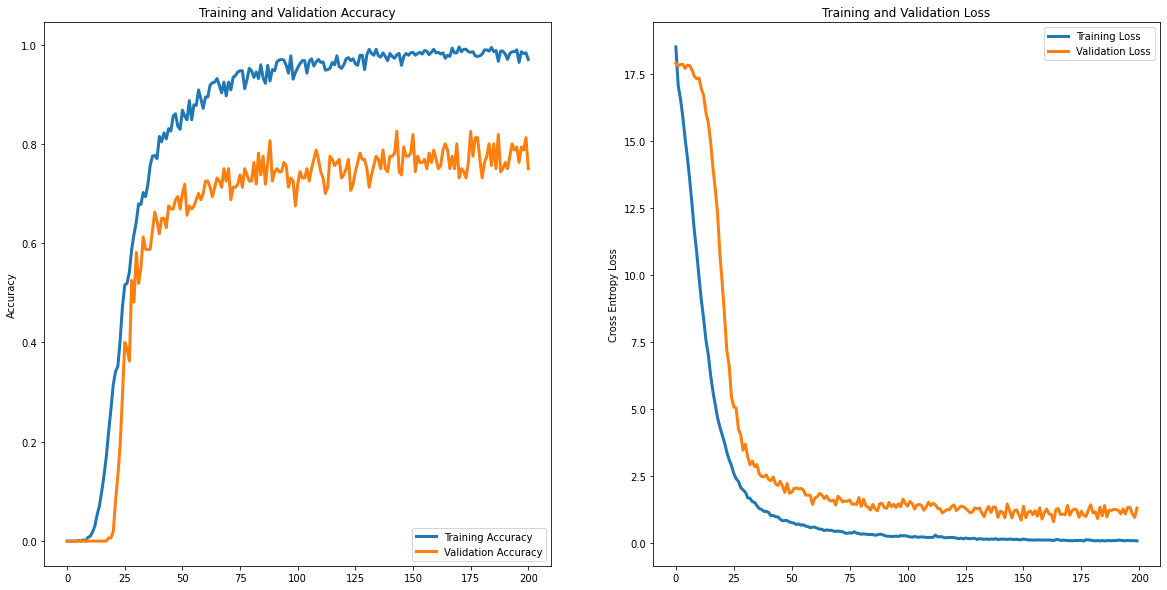

KeyboardInterrupt: ignored

In [221]:
if __name__=="__main__":
  net = NN()
  training, validation, test = net.load_data("AI_Medic/Internship/CAPTCHA_project/data", 32, 0.75, 0.15)
  labels_dict = net.labels_dict
  words_dict = dict((v, k) for k, v in labels_dict.items())
  model = tf.keras.models.load_model('AI_Medic/Internship/CAPTCHA_project/saved model/new', compile=False)
  with open('/content/Final_history.pkl', 'rb') as f:
        new_history = pickle.load(f)
        history = History(new_history)
  command = ''
  while command != 'exit':
    command = input("Please insert your command:" + "\n" + "insert number 1 to plot training loss and accuracy history" +  "\n" + "insert number 2 to plot some model predictions on test dataset"+ "\n" + "and insert number 3 to start a new training process" + "\n")    
    if command == '1':
      re = Results(history, model)
      re.plot_loss_accuracy()
    elif command == '2':
      re = Results(history, model)
      re.test(test)
    elif command == '3':
      model = net.load_model()
      epochs = int(input('please enter number of epochs (at least 100 would be desired)'))
      history = model.fit(training,validation_data=validation, epochs=200, callbacks=[net.call_back])
    else:
      print('please insert right command')
